# <center> How to use the Ladder3 class

In [1]:
import numpy as np
import sys, os
import matplotlib.pyplot as plt
from tqdm import *
from datetime import date
import multiprocessing as mp
from multiprocessing import Pool
from Ladder_3_wrapper import L3

# sys.path.insert(0, "../bin")
# from Ladder_3 import Ladder_3
# obj = Ladder_3()

In [2]:
def parameter_conversion(new_par): 
    """ 
    A function to convert Ladder3 parameters to conform with the 
    parameters order in Ladder_3.cpp: 
        
        cpp_param = [ a12, a23, b12, b23, a12T, a23T, b12T, b23T, kon, koff, P, PT ]

    Use this function to implement specific parameter patterns
    """
    
    cpp_param = np.zeros(12)
    
    cpp_param[[0,1]]   = new_par[[0,1]]  # a12, a23 
    cpp_param[[4,5]]   = new_par[[4,5]]  # a12T, a23T
    cpp_param[[2,3]]   = new_par[[2,3]]  # b12, b23
    cpp_param[[6,7]]   = new_par[[6,7]]  # b12T, b23T
    cpp_param[[8,9]]   = new_par[[8,9]]  # kon, koff 
    cpp_param[[10,11]] = new_par[10]     # P 
    
    return cpp_param

## >  Setting up the rejection range for initial mean FPT

In [3]:
obj = L3() # instantiate the ladder 3 class, you can look at the methods with dir(obj) and use obj.METHOD? for the docstring

In [4]:
p_log_range = 3                # log-range of the parameters [-3, 3]
initial_tf_conc_range = 20     # log-range of the initial TF concentration range [-20, 20]
th_deltaR = 1                  # treshold setted at 1, i.e. the initial TF conc range is not trimmed
n_sampled_params = int(1e4)    # number of points to sample


initial_mean_FPT   = []
for i in tqdm(range(n_sampled_params)):
    # Sample paramters and set the laplacian matrix
    p = 10**np.random.uniform(-p_log_range, p_log_range, 11) 
    pars = parameter_conversion(p)
    obj.setLaplacian_ladder_3(pars)
    
    # Multiply the laplacian by the initial TF concentration
    obj.mult_laplacian_TF(10**(-initial_tf_conc_range))
    
    # Compute the initial mean FPT
    ini_mean_FPT = obj.get_FPT_stat(True)[0]
    initial_mean_FPT.append(ini_mean_FPT)

    
# we select as rejection range the points with initial mean FPT outside the first and third quantile
qt1, qt3 = np.percentile(np.log10(initial_mean_FPT), 25), np.percentile(np.log10(initial_mean_FPT), 75)

100%|███████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2147.22it/s]


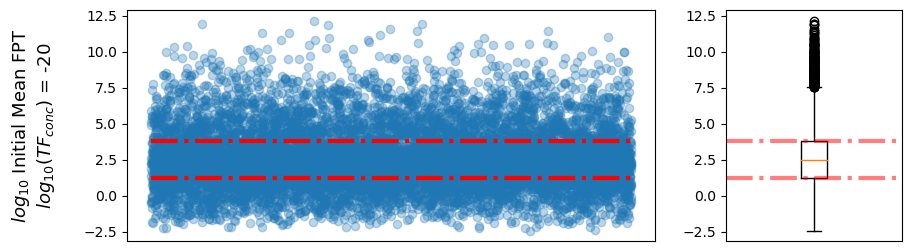

In [5]:
# Some plotting

fig, axs = plt.subplots(1,2, gridspec_kw={'width_ratios': [3, 1]}, figsize = (10, 3))

axs[0].plot(np.log10(initial_mean_FPT), "o", alpha = 0.3);
axs[0].hlines(qt1, 0, len(initial_mean_FPT), lw = 3, ls = "-.", color = "red");
axs[0].hlines(qt3, 0, len(initial_mean_FPT), lw = 3, ls = "-.", color = "red");
axs[0].set_ylabel("$log_{10}$ Initial Mean FPT"+"\n"+"$log_{10}(TF_{conc})$ "+"="+f" {-initial_tf_conc_range} \n",
                  fontsize = 13);
axs[0].set_xticks([]);

axs[1].boxplot(np.log10(initial_mean_FPT));
axs[1].hlines(qt1, 0.5, 1.5, lw = 3, ls = "-.", color = "red", alpha = 0.5);
axs[1].hlines(qt3, 0.5, 1.5, lw = 3, ls = "-.", color = "red", alpha = 0.5);
axs[1].set_xticks([]); 

## > Score random sampling (parallel)

In [6]:
p_log_range = 3                      # log10 parameter range
initial_tf_conc_range = 20           # initial TF concentration range
th_deltaR = 1                        # when th_deltaR = 1 the TF conc range used for the score computation is equal to the initial
n_sampled_params = 500               # number of sampled parameters x number of cpus 
n_points = 100                       # number of points on which computing the FPT score
low_mean, up_mean = 10**qt1, 10**qt3 # rejection range for the initial mean FPT

In [7]:
def sampling_process(seed):

    global p_log_range, initial_tf_conc_range, th_deltaR, n_sampled_params, n_points, low_mean, up_mean
    
    np.random.seed(seed)
    # print(f"Process {seed} Started \n")
    delta_ss_responses = []
    scores = []
    parameters = []

    for i in tqdm(range(n_sampled_params)):

        # sample parameters and set laplacian matrix
        p = 10**np.random.uniform(-p_log_range, p_log_range, 11) 
        pars = parameter_conversion(p)
        obj.setLaplacian_ladder_3(pars)

        # compute range (since th_deltaR == 1 the range will be -20, 20)
        TF_range = obj.triming([-initial_tf_conc_range, initial_tf_conc_range], 100, th_deltaR)

        # compute score with rejection setted by the qt1 and qt3)
        score = obj.simple_score([TF_range[0], TF_range[1]], n_points, low_mean, up_mean)
        scores.append(score)
        delta_ss_responses.append(TF_range[2])
        parameters.append(pars)

    delta_ss_responses = np.array(delta_ss_responses)
    scores = np.array(scores)
    parameters = np.array(parameters) 
    
    return delta_ss_responses, scores, parameters

In [8]:
if __name__ == '__main__':
    max_proc = 8 # equal to the number of cpus on your machine
    with Pool(processes = mp.cpu_count()) as p:
        %time parallel_results = p.map(sampling_process, np.arange(0, max_proc))

        
# merge resoults
delta_ss_responses = [] 
scores = [] 
parameters = []

for res in parallel_results:
    for j in range(len(res[0])): 
        delta_ss_responses.append(res[0][j])
        scores.append(res[1][j,:])
        parameters.append(res[2][j,:])
        
delta_ss_responses = np.array(delta_ss_responses)
scores = np.array(scores)
parameters = np.array(parameters)

100%|█████████████████████████████████████████████████████████████████████████████████████| 500/500 [06:18<00:00,  1.32it/s]


CPU times: user 5.7 s, sys: 1.32 s, total: 7.02 s
Wall time: 6min 18s


(-0.1, 1.1)

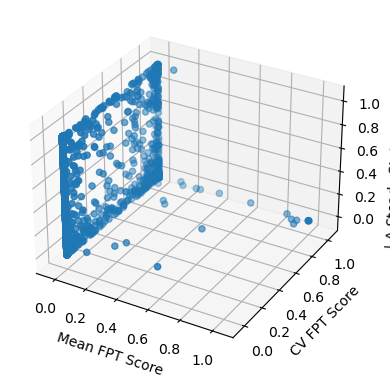

In [9]:
# Some shitty plotting
computed_filt = np.sum(scores>[-1,-1], 1) == 2

fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.scatter(scores[computed_filt][:,0], scores[computed_filt][:,1],
           delta_ss_responses[computed_filt])

ax.set_xlabel('Mean FPT Score')
ax.set_ylabel('CV FPT Score')
ax.set_zlabel('| $\Delta$ Steady State Response |')
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)
ax.set_zlim(-0.1,1.1)

## > Compute Response Profiles

In [48]:
# sample randomply a parameter set
p = 10**np.random.uniform(-p_log_range, p_log_range, 11) 
pars = parameter_conversion(p)
obj.setLaplacian_ladder_3(pars)

# compute responses, profiles
tf_conc_ranges = np.logspace(-20, 20, 100)
mean_fpt_response = []
steady_state_response = []

for tf_conc in tf_conc_ranges: 
    obj.mult_laplacian_TF(tf_conc) # Set tf conc laplacian
    mean_fpt_response.append(obj.get_FPT_stat(True)[0]) # compute mean FPT at concentration tf_conc
    steady_state_response.append(obj.compute_response(tf_conc)) # compute ss response at concentration tf_conc

Text(0.5, 0, 'log10 TF concentration')

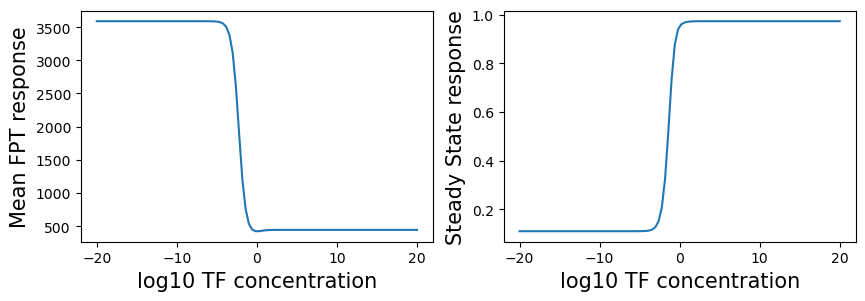

In [49]:
# some basic plotting

fig, axs = plt.subplots(1, 2, figsize = (10, 3))

axs[0].plot(np.log10(tf_conc_ranges), mean_fpt_response)
axs[1].plot(np.log10(tf_conc_ranges), steady_state_response)

axs[0].set_ylabel("Mean FPT response", fontsize = 15)
axs[1].set_ylabel("Steady State response", fontsize = 15)
axs[0].set_xlabel("log10 TF concentration", fontsize = 15)
axs[1].set_xlabel("log10 TF concentration", fontsize = 15)